In [2]:
import pandas as pd
import numpy as np
import random
import math

import requests

#Herramientas geo
import geopandas as gpd
from shapely.geometry import Point
from geopy.distance import distance
from geopy.distance import geodesic
import folium
from folium import Choropleth, Marker, GeoJson
from folium.plugins import HeatMap, MarkerCluster

#Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# AIRBNB

In [3]:
#Tipo de cambio al 29-12-23
TDC_airbnb = 1025

## Atributos geo

### Distancia a estaciones e infraestructura social

In [5]:
barrios_airbnb = gpd.read_file("neighbourhoods.geojson")
barrios_airbnb.head()

,neighbourhood,neighbourhood_group,geometry
0,Chacarita,None,"MULTIPOLYGON (((-58.45282 -34.59599, -58.45366..."
1,Villa Crespo,None,"MULTIPOLYGON (((-58.42375 -34.59783, -58.42496..."
2,Palermo,None,"MULTIPOLYGON (((-58.42676 -34.55202, -58.42676..."
3,Parque Chas,None,"MULTIPOLYGON (((-58.47082 -34.58745, -58.47082..."
4,Villa Del Parque,None,"MULTIPOLYGON (((-58.49461 -34.61487, -58.49479..."


In [6]:
#estaciones de subte
subtes = gpd.read_file("https://cdn.buenosaires.gob.ar/datosabiertos/datasets/sbase/subte-estaciones/estaciones-de-subte.geojson")
subtes.shape

(90, 4)

In [7]:
trenes = gpd.read_file("https://cdn.buenosaires.gob.ar/datosabiertos/datasets/transporte-y-obras-publicas/estaciones-ferrocarril/estaciones-de-ferrocarril.geojson")
trenes.shape

(230, 12)

In [8]:
metrobus = gpd.read_file("https://cdn.buenosaires.gob.ar/datosabiertos/datasets/transporte-y-obras-publicas/metrobus/estaciones-de-metrobus.geojson")
metrobus.shape

(379, 30)

In [9]:
lineas = gpd.read_file("https://cdn.buenosaires.gob.ar/datosabiertos/datasets/transporte-y-obras-publicas/colectivos-recorridos/recorrido-colectivo.geojson")
lineas.shape

(1104, 10)

In [10]:
bicis = gpd.read_file("https://cdn.buenosaires.gob.ar/datosabiertos/datasets/transporte-y-obras-publicas/estaciones-bicicletas-publicas/nuevas-estaciones-bicicletas-publicas.geojson")
bicis.shape

(471, 12)

In [11]:
hospitales = gpd.read_file("https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-salud/hospitales/hospitales.geojson")
hospitales.shape

(36, 20)

In [12]:
escuelas = gpd.read_file("https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/establecimientos-educativos/establecimientos_educativos_WGS84.geojson")
escuelas.shape

(2973, 28)

In [13]:
#defino la proyección adecuada para estas latitudes y en metros
crs_proyectado = 'EPSG:5348'

In [14]:
from sklearn.cluster import DBSCAN

Ver: https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/


https://stackoverflow.com/questions/34579213/dbscan-for-clustering-of-geographic-location-data

In [15]:
#Defino hiperparámetros del modelo

from geopy import distance

def mydist(p1, p2):
  return distance.great_circle((p1[0],p1[1],100),(p2[0],p2[1],100)).meters

# kms_per_radian = 6371.0088
# epsilon = 0.1 / kms_per_radian


In [16]:
# data.to_csv("Base Airbnb CABA con atributos GEO.csv")

In [17]:
data = pd.read_csv("Base Airbnb CABA con atributos GEO.csv")

# Modelos de Regresión

In [18]:
# Creamos funcion para etiquetar dummies

def nombres_dummies(dataset,drop=True): #Defino nombre de funcion y parámetros
  s = (dataset.dtypes == 'object')   #Listo variables objeto
  object_cols = list(s[s].index)

  for col in object_cols: #Corro un for loop para cada item en la lista
    dummies = pd.get_dummies(dataset[col], prefix=f"Dm_{col}") #Corro get_dummies para cada variable
    dataset = pd.concat([dataset, dummies], axis=1) #Concateno las variables nuevas
    if drop==True: #Elimino variables originales
      dataset.drop(col, axis=1, inplace=True)

  return dataset # Devuelvo el dataset

In [19]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [20]:
# data.columns.values

In [21]:
mono_precio = data[['latitude','longitude',#'baños',
        'subte_dist', 'trenes_dist',
       'metrob_dist', 'hosp_dist', 'bicis_dist', 'escuelas_dist',
       'subtes_5', 'trenes_5', 'metro_5', 'bicis_5','dbscan','barrio','precio']]
mono_precio.shape

(11113, 15)

In [22]:
#Codifico barrios
# neighbourhood_cleansed

In [23]:
mono_precio = mono_precio.dropna()
mono_precio.shape

(11113, 15)

In [24]:
mono_precio.isnull().sum()

latitude         0
longitude        0
subte_dist       0
trenes_dist      0
metrob_dist      0
hosp_dist        0
bicis_dist       0
escuelas_dist    0
subtes_5         0
trenes_5         0
metro_5          0
bicis_5          0
dbscan           0
barrio           0
precio           0
dtype: int64

In [25]:
#Separo la variable target/objetivo
X = nombres_dummies(mono_precio.drop(['precio'], axis=1))
y = mono_precio['precio']

#Dividio en train y test con una proporción de 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=724)
print("Encoding listo. usar dfs:\nX_train, X_test, y_train, y_test")

Encoding listo. usar dfs:
X_train, X_test, y_train, y_test


In [26]:
# Normalizando los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## KNN Regresor

In [27]:
from sklearn.neighbors import KNeighborsRegressor

In [28]:
#Instancio el modelo
knn_model = KNeighborsRegressor(n_neighbors=5)

knn_model.fit(X_train_scaled, y_train)

KNeighborsRegressor()

In [29]:
from sklearn.metrics import mean_squared_error
from math import sqrt

train_preds = knn_model.predict(X_train_scaled)
mse = mean_squared_error(y_train, train_preds)
rmse = sqrt(mse)
rmse

2910.192423218348

In [30]:
test_preds = knn_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, test_preds)
rmse = sqrt(mse)
rmse

3529.4156765741955

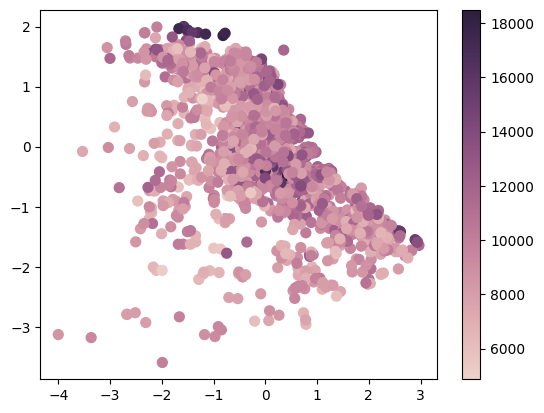

In [31]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], c=test_preds, s=50, cmap=cmap)
f.colorbar(points)
plt.show()

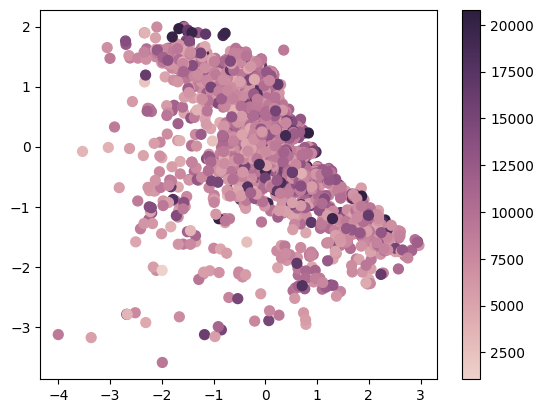

In [32]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], c=y_test, s=50, cmap=cmap)
f.colorbar(points)
plt.show()

In [33]:
#Optimizo el modelo usando gridserhc, para encontrar el nro correcto de K
from sklearn.model_selection import GridSearchCV

parameters = {"n_neighbors": range(1, 50)}
gridsearch = GridSearchCV(KNeighborsRegressor(), parameters, verbose= 3)
gridsearch.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 49 candidates, totalling 245 fits
[CV 1/5] END ....................n_neighbors=1;, score=-0.636 total time=   0.1s
[CV 2/5] END ....................n_neighbors=1;, score=-0.548 total time=   0.1s
[CV 3/5] END ....................n_neighbors=1;, score=-0.566 total time=   0.1s
[CV 4/5] END ....................n_neighbors=1;, score=-0.556 total time=   0.1s
[CV 5/5] END ....................n_neighbors=1;, score=-0.630 total time=   0.1s
[CV 1/5] END ....................n_neighbors=2;, score=-0.226 total time=   0.1s
[CV 2/5] END ....................n_neighbors=2;, score=-0.257 total time=   0.1s
[CV 3/5] END ....................n_neighbors=2;, score=-0.186 total time=   0.1s
[CV 4/5] END ....................n_neighbors=2;, score=-0.207 total time=   0.1s
[CV 5/5] END ....................n_neighbors=2;, score=-0.237 total time=   0.1s
[CV 1/5] END ....................n_neighbors=3;, score=-0.098 total time=   0.1s
[CV 2/5] END ....................n_neighbors=3;

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(1, 50)}, verbose=3)

In [34]:
print("Mejores parámetros:")
gridsearch.best_params_

Mejores parámetros:


{'n_neighbors': 38}

In [35]:
#Entreno el modelo con los mejores parámetros identificados
knn_model = KNeighborsRegressor(n_neighbors=gridsearch.best_params_['n_neighbors'])

knn_model.fit(X_train_scaled, y_train)

KNeighborsRegressor(n_neighbors=38)

In [36]:
train_preds = knn_model.predict(X_train_scaled)
mse = mean_squared_error(y_train, train_preds)
rmse = sqrt(mse)
rmse

3316.5736368054067

In [37]:
test_preds = knn_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, test_preds)
rmse = sqrt(mse)
rmse

3364.5481130920384

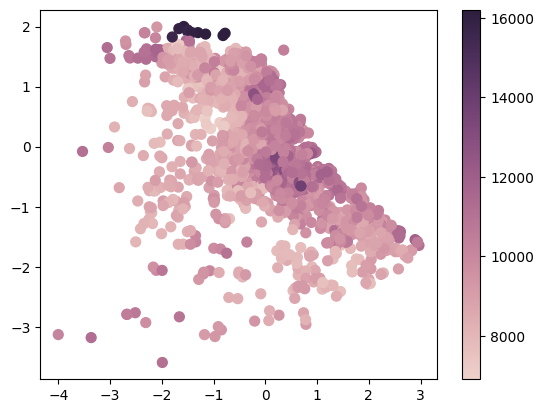

In [38]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], c=test_preds, s=50, cmap=cmap)
f.colorbar(points)
plt.show()

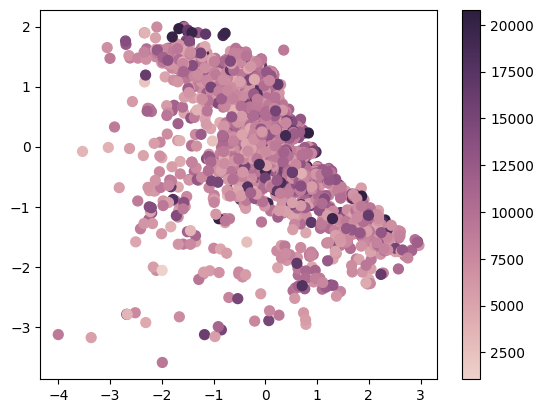

In [39]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], c=y_test, s=50, cmap=cmap)
f.colorbar(points)
plt.show()

## Linnear regression

In [40]:
from sklearn.metrics import mean_absolute_error

In [41]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

# fitting the model
model.fit(X_train, y_train)

# making predictions
predictions = model.predict(X_test)

# model evaluation
print('mean_squared_error : ', mean_squared_error(y_test, predictions))
print('mean_absolute_error : ', mean_absolute_error(y_test, predictions))

mean_squared_error :  11375421.97387382
mean_absolute_error :  2641.7777412499995


## Decision tree regressor

In [42]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(random_state=724)

# Entreno Modelo
model.fit(X_train, y_train)

# Make validation predictions and calculate mean absolute error
val_predictions = model.predict(X_test)
val_mae = mean_absolute_error(val_predictions, y_test)
print(f"Validation MAE when not specifying max_leaf_nodes: {round(val_mae,1)} ")

Validation MAE when not specifying max_leaf_nodes: 3449.3 


In [43]:
model = DecisionTreeRegressor(random_state=724)

# Entreno Modelo
model.fit(X_train_scaled, y_train)

# Make validation predictions and calculate mean absolute error
val_predictions = model.predict(X_test_scaled)
val_mae = mean_absolute_error(val_predictions, y_test)
print(f"Validation MAE when not specifying max_leaf_nodes: {round(val_mae,1)} ")

Validation MAE when not specifying max_leaf_nodes: 3486.8 


In [44]:
data.precio.mean()

9726.595248807702

## Random Tree Regressor

In [45]:
from sklearn.ensemble import RandomForestRegressor

# Define the model. Set random_state to 724
rf_model = RandomForestRegressor(random_state=724)

# fit your model
rf_model.fit(X_train,y_train)

# Calculo el error absoluto promedio
rf_val_predictions = rf_model.predict(X_test)
rf_val_mae = mean_absolute_error(y_test, rf_model.predict(X_test))

print("Validation MAE for Random Forest Model: {}".format(round(rf_val_mae,1)))

Validation MAE for Random Forest Model: 2680.9


In [46]:
#Evaluamos la importancia(Peso explicativo) de las variables)
feature_importances_df = pd.DataFrame(
    {"feature": list(X_train.columns), "importance": rf_model.feature_importances_}
    ).sort_values("importance", ascending=False)

# Mostrar
feature_importances_df.head(15)

,feature,importance
0,latitude,0.130049
6,bicis_dist,0.120379
1,longitude,0.117369
7,escuelas_dist,0.113896
2,subte_dist,0.105752
3,trenes_dist,0.096609
4,metrob_dist,0.088945
5,hosp_dist,0.088487
12,dbscan,0.031670
11,bicis_5,0.026707


In [47]:
# Define the model. Set random_state to 724
rf_model = RandomForestRegressor(random_state=724)

# fit your model
rf_model.fit(X_train_scaled,y_train)

# Calculo el error absoluto promedio
rf_val_predictions = rf_model.predict(X_test_scaled)
rf_val_mae = mean_absolute_error(y_test, rf_model.predict(X_test_scaled))

print("Validation MAE for Random Forest Model: {}".format(round(rf_val_mae,1)))

Validation MAE for Random Forest Model: 2680.8


In [48]:
#Evaluamos la importancia(Peso explicativo) de las variables)
feature_importances_df = pd.DataFrame(
    {"feature": list(X_train.columns), "importance": rf_model.feature_importances_}
    ).sort_values("importance", ascending=False)

# Mostrar
feature_importances_df.head(15)

,feature,importance
0,latitude,0.131768
6,bicis_dist,0.120416
1,longitude,0.119210
7,escuelas_dist,0.113073
2,subte_dist,0.105015
3,trenes_dist,0.096016
4,metrob_dist,0.088455
5,hosp_dist,0.087691
12,dbscan,0.031707
11,bicis_5,0.026611


## XGBOOST

In [49]:
from sklearn.model_selection import cross_val_score, StratifiedKFold,GridSearchCV
from xgboost import XGBRegressor

In [50]:
# Definir el modelo XGBoost para regresión
xg_model = XGBRegressor(random_state=724)

# Definir la estrategia de validación cruzada estratificada
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=724)

# Realizar la validación cruzada estratificada
mae_scores = cross_val_score(xg_model, X, y, cv=stratified_kfold, scoring='neg_mean_absolute_error')

# Calcular el promedio del MAE (se utiliza neg_mean_absolute_error ya que cross_val_score maximiza la métrica)
avg_mae = np.mean(-mae_scores)

print("Validation MAE for XGBoost regresor: {}".format(round(avg_mae,1)))

Validation MAE for XGBoost regresor: 2686.5


In [51]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [52]:
xg_model = XGBRegressor(random_state=724)

param_grid = {
        'n_estimators': [50,100, 200, 300,400],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7]
    }

halving_cv = HalvingGridSearchCV(xg_model, param_grid,cv=stratified_kfold, scoring="neg_mean_absolute_error", n_jobs=-1,verbose=1,random_state=724)
halving_cv.fit(X_train, y_train)


print("Mejores parametros", halving_cv.best_params_)
print("Mejor Score CV", -halving_cv.best_score_)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 329
max_resources_: 8890
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 45
n_resources: 329
Fitting 5 folds for each of 45 candidates, totalling 225 fits
----------
iter: 1
n_candidates: 15
n_resources: 987
Fitting 5 folds for each of 15 candidates, totalling 75 fits
----------
iter: 2
n_candidates: 5
n_resources: 2961
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 3
n_candidates: 2
n_resources: 8883
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Mejores parametros {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Mejor Score CV 2615.6375023094383


In [53]:
# Definir el modelo XGBoost para regresión
xg_model = XGBRegressor(random_state=724,learning_rate= 0.05, max_depth=5, n_estimators=50)

# Definir la estrategia de validación cruzada estratificada
# stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=724)

xg_model.fit(X_train, y_train)

# Realizar la validación cruzada estratificada

xg_val_predictions = xg_model.predict(X_test)
xg_val_mae = mean_absolute_error(y_test, xg_model.predict(X_test))

print("Validation MAE for Xgboost: {}".format(round(xg_val_mae,1)))

Validation MAE for Xgboost: 2607.4


In [54]:
#Evaluamos la importancia(Peso explicativo) de las variables)
feature_importances_df = pd.DataFrame(
    {"feature": list(X_train.columns), "importance": xg_model.feature_importances_}
    ).sort_values("importance", ascending=False)

# Mostrar
feature_importances_df.head(20)

,feature,importance
39,Dm_barrio_Puerto Madero,0.362571
0,latitude,0.098474
1,longitude,0.072422
16,Dm_barrio_Barracas,0.057188
10,metro_5,0.041404
4,metrob_dist,0.035316
17,Dm_barrio_Belgrano,0.035043
11,bicis_5,0.033924
8,subtes_5,0.025453
3,trenes_dist,0.024839


# Argenprop

## Atributos geo para prediccion de ingresos x airbnb

In [148]:
#Utilizo KNN clasiffier para identificar a cual cluster de dbscan de airbnb pertenece cada propiedad de argenprop
# from sklearn.neighbors import KNeighborsClassifier

# # Paso 2: Entrenar el modelo KNN
# k = 5  # número de vecinos
# knn_model = KNeighborsClassifier(n_neighbors=k)
# knn_model.fit(data[['latitude','longitude']], data[['dbscan']])

# # Paso 3: Realizar predicciones para el segundo DataFrame
# predictions = knn_model.predict(props[['latitud', 'longitud']].rename(columns={'latitud':'latitude', 'longitud':'longitude'}))

# # Agregar predicciones al segundo DataFrame
# props['dbscan'] = predictions
# print(f"Cantidad de Clusters: {props.dbscan.nunique()}")
# print(f"Cantidad de Componentes aislados: {props[props['dbscan']==-1].shape[0]} - {round(props[props['dbscan']==-1].shape[0]/props.shape[0] * 100,1)} % ")

In [149]:
props = pd.read_csv("Monoambientes ARGENPROP con precios de AIRBNB.csv")
props.drop(['Unnamed: 0','oportunidad','oportunidad2','Precio_vf_barrio', 'precio_airbnb_barrio', 'airbnb_usd_barrio',
       'armortiza_barrio', 'ingreso_anualizado_usd_barrio', 'ROI_barrio'],axis=1,inplace=True)
props.shape

(6669, 47)

Cantidad de Clusters: 330
Cantidad de Componentes aislados: 4370 - 65.5 % 


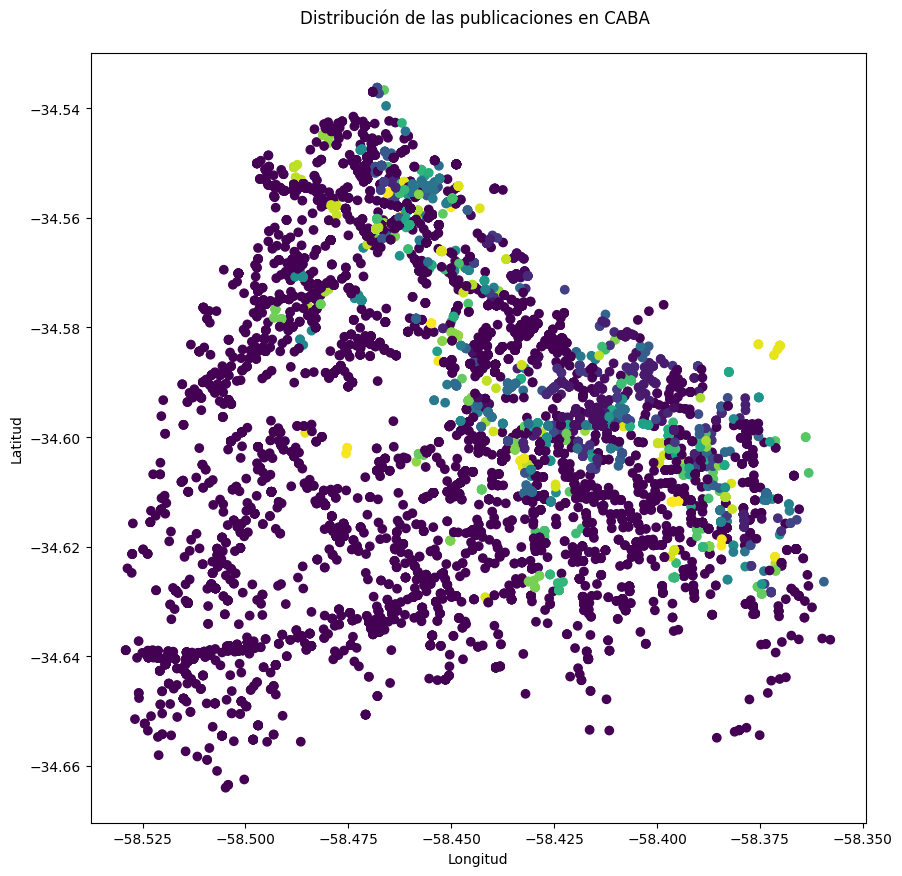

In [150]:
#Grafico los clusters de la oferta de argenprop
fig, ax = plt.subplots(figsize= [10, 10])
ax.scatter(props['longitud'], props['latitud'], c = props['dbscan'])
ax.set_title('Distribución de las publicaciones en CABA \n ')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
print(f"Cantidad de Clusters: {props.dbscan.nunique()}")
print(f"Cantidad de Componentes aislados: {props[props['dbscan']==-1].shape[0]} - {round(props[props['dbscan']==-1].shape[0]/props.shape[0] * 100,1)} % ")
plt.show()

In [151]:
#Codifico las variables dummies
barrios_sin_airbnb = ['Villa Lugano','Villa Soldati','Villa Riachuelo']

props2 = props[~props.neighbourhood.isin(barrios_sin_airbnb)]
XX = nombres_dummies(props2[['latitud','longitud',
        'subte_dist', 'trenes_dist',
       'metrob_dist', 'hosp_dist', 'bicis_dist', 'escuelas_dist',
       'subtes_5', 'trenes_5', 'metro_5', 'bicis_5','dbscan','neighbourhood','Precio_vf']].rename(columns={'latitud':'latitude','longitud':'longitude','neighbourhood':'barrio','Precio_vf':'precio'}))
yy = XX.pop('precio')

# #Dividio en train y test con una proporción de 80-20
# XX_train, XX_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=724)
# print("Encoding listo. usar dfs:\nX_train, X_test, y_train, y_test")

In [152]:
# Normalizando los datos
# XX_scaled = scaler.transform(XX)

## Prediccion XGBOOST

In [153]:
#Predigo usando el modelo XGBoost ya entrenado previamente usando airbnb

xg_val_predictions_AP = xg_model.predict(XX)
props2['precio_airbnb'] = xg_val_predictions_AP

props2['precio_airbnb'].describe()

count     6669.000000
mean      8871.354492
std        966.553223
min       6672.201172
25%       8244.913086
50%       8559.168945
75%       9281.318359
max      16491.906250
Name: precio_airbnb, dtype: float64

In [154]:
data.precio.describe()

count    11113.000000
mean      9726.595249
std       3593.560886
min        600.000000
25%       7133.000000
50%       8943.000000
75%      11498.000000
max      20806.000000
Name: precio, dtype: float64

In [155]:
props['precio_airbnb'] = xg_val_predictions_AP

In [156]:
#Evaluamos la importancia(Peso explicativo) de las variables)
feature_importances_df = pd.DataFrame(
    {"feature": list(XX.columns), "importance": xg_model.feature_importances_}
    ).sort_values("importance", ascending=False)

# Mostrar
feature_importances_df.head(20)

,feature,importance
39,Dm_barrio_Puerto Madero,0.362571
0,latitude,0.098474
1,longitude,0.072422
16,Dm_barrio_Barracas,0.057188
10,metro_5,0.041404
4,metrob_dist,0.035316
17,Dm_barrio_Belgrano,0.035043
11,bicis_5,0.033924
8,subtes_5,0.025453
3,trenes_dist,0.024839


In [157]:
props2.head()

,Clase,Barrio,Ubicacion,Descripcion,Precio,Links,fecha_consulta,tipo_prop,operacion,Barrio_vf,...,dbscan,precio_airbnb,distancia_a_tendencia,distancia_norm_above,distancia_norm_below,dist_norms,airbnb_usd,armortiza,ingreso_anualizado_usd,ROI
0,"Departamento en Venta en Caballito Norte, Caba...","Caballito Norte, Caballito",Beláustegui 1100,Monoambiente con Patio en Venta,USD 45.000+$10.000expensas,https://www.argenprop.com/departamento-en-vent...,2024_03_01,Departamento,Venta,Caballito Norte,...,-1,8676.149414,3544.677413,NaN,0.322999,0.322999,8.464536,5316.298675,3089.5554,6.87
1,"Departamento en Venta en Recoleta, Barrio Norte","Recoleta, Barrio Norte",Anchorena al 1800,Monoambiente en Venta en Recoleta,USD 72.000+$33.000expensas,https://www.argenprop.com/departamento-en-vent...,2024_03_01,Departamento,Venta,Recoleta,...,42,9673.549805,1813.866143,NaN,0.165207,0.165207,9.437610,7629.050416,3444.7275,4.78
2,"Departamento en Venta en Almagro, Capital Federal","Almagro, Capital Federal",AVENIDA CORRIENTES 3800,Departamento Monoambiente en Venta en Almagro ...,USD 99.999,https://www.argenprop.com/departamento-en-vent...,2024_03_01,Departamento,Venta,Almagro,...,84,8825.468750,1853.771588,0.224368,NaN,0.224368,8.610213,11613.998022,3142.7278,3.14
3,"Departamento en Venta en Recoleta, Barrio Norte","Recoleta, Barrio Norte",Paraguay al 2400,Departamento Monoambiente con Balcon a Estrena...,USD 95.000,https://www.argenprop.com/departamento-en-vent...,2024_03_01,Departamento,Venta,Recoleta,...,352,8953.311523,1222.399558,0.147919,NaN,0.147919,8.734938,10875.864673,3188.2522,3.36
4,"Departamento en Venta en Almagro Sur, Almagro","Almagro Sur, Almagro",Boedo al 200,Monoambiente Gran Categoría C/ Excelentes Amen...,USD 48.400,https://www.argenprop.com/departamento-en-vent...,2024_03_01,Departamento,Venta,Almagro Sur,...,-1,8274.977539,2802.638995,NaN,0.255350,0.255350,8.073149,5995.182504,2946.6992,6.09


In [158]:
props2[props2['Precio_vf']>150000].shape

(0, 47)

In [159]:
props2 = props2[props2['Precio_vf']<=150000]

In [160]:
props2.shape

(6669, 47)

#RESULTADOS

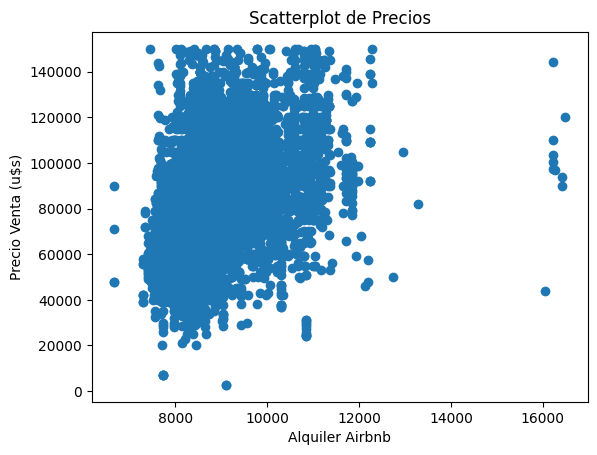

In [161]:
plt.scatter(props2['precio_airbnb'], props2['Precio_vf'])

# Añadir título y etiquetas de los ejes
plt.title('Scatterplot de Precios')
plt.xlabel('Alquiler Airbnb')
plt.ylabel('Precio Venta (u$s)')

# Mostrar el gráfico
plt.show()

In [162]:
#Crear una variable de distancia de la linea de tendencia y usarla para darle el alpha

In [163]:
coeficientes = np.polyfit(props2['precio_airbnb'], props2['Precio_vf'], 1)
pendiente = coeficientes[0]
intercepto = coeficientes[1]

# Calcular la distancia perpendicular desde cada punto al la línea de tendencia
distancia = np.abs(pendiente * props2['precio_airbnb'] - props2['Precio_vf'] + intercepto) / np.sqrt(pendiente**2 + 1)

# Agregar la variable de distancia al DataFrame
props2['distancia_a_tendencia'] = distancia

# Visualizar el DataFrame con la nueva variable
props2.head()

,Clase,Barrio,Ubicacion,Descripcion,Precio,Links,fecha_consulta,tipo_prop,operacion,Barrio_vf,...,dbscan,precio_airbnb,distancia_a_tendencia,distancia_norm_above,distancia_norm_below,dist_norms,airbnb_usd,armortiza,ingreso_anualizado_usd,ROI
0,"Departamento en Venta en Caballito Norte, Caba...","Caballito Norte, Caballito",Beláustegui 1100,Monoambiente con Patio en Venta,USD 45.000+$10.000expensas,https://www.argenprop.com/departamento-en-vent...,2024_03_01,Departamento,Venta,Caballito Norte,...,-1,8676.149414,3544.677413,NaN,0.322999,0.322999,8.464536,5316.298675,3089.5554,6.87
1,"Departamento en Venta en Recoleta, Barrio Norte","Recoleta, Barrio Norte",Anchorena al 1800,Monoambiente en Venta en Recoleta,USD 72.000+$33.000expensas,https://www.argenprop.com/departamento-en-vent...,2024_03_01,Departamento,Venta,Recoleta,...,42,9673.549805,1813.866143,NaN,0.165207,0.165207,9.437610,7629.050416,3444.7275,4.78
2,"Departamento en Venta en Almagro, Capital Federal","Almagro, Capital Federal",AVENIDA CORRIENTES 3800,Departamento Monoambiente en Venta en Almagro ...,USD 99.999,https://www.argenprop.com/departamento-en-vent...,2024_03_01,Departamento,Venta,Almagro,...,84,8825.468750,1853.771588,0.224368,NaN,0.224368,8.610213,11613.998022,3142.7278,3.14
3,"Departamento en Venta en Recoleta, Barrio Norte","Recoleta, Barrio Norte",Paraguay al 2400,Departamento Monoambiente con Balcon a Estrena...,USD 95.000,https://www.argenprop.com/departamento-en-vent...,2024_03_01,Departamento,Venta,Recoleta,...,352,8953.311523,1222.399558,0.147919,NaN,0.147919,8.734938,10875.864673,3188.2522,3.36
4,"Departamento en Venta en Almagro Sur, Almagro","Almagro Sur, Almagro",Boedo al 200,Monoambiente Gran Categoría C/ Excelentes Amen...,USD 48.400,https://www.argenprop.com/departamento-en-vent...,2024_03_01,Departamento,Venta,Almagro Sur,...,-1,8274.977539,2802.638995,NaN,0.255350,0.255350,8.073149,5995.182504,2946.6992,6.09


In [164]:
from numpy.polynomial.polynomial import Polynomial
poly1d_fn = Polynomial.fit(props2['precio_airbnb'], props2['Precio_vf'], 1)

In [165]:
props2['distancia_norm_above'] = np.nan
props2['distancia_norm_below'] = np.nan

# Normalizar las distancias para los puntos por encima de la línea de tendencia
max_dist_above = props2[props2['Precio_vf'] >= poly1d_fn(props2['precio_airbnb'])]['distancia_a_tendencia'].max()
min_dist_above = props2[props2['Precio_vf'] >= poly1d_fn(props2['precio_airbnb'])]['distancia_a_tendencia'].min()
props2.loc[props2['Precio_vf'] >= poly1d_fn(props2['precio_airbnb']), 'distancia_norm_above'] = (props2['distancia_a_tendencia'] - min_dist_above) / (max_dist_above - min_dist_above)

# Normalizar las distancias para los puntos por debajo de la línea de tendencia
max_dist_below = props2[props2['Precio_vf'] < poly1d_fn(props2['precio_airbnb'])]['distancia_a_tendencia'].max()
min_dist_below = props2[props2['Precio_vf'] < poly1d_fn(props2['precio_airbnb'])]['distancia_a_tendencia'].min()
props2.loc[props2['Precio_vf'] < poly1d_fn(props2['precio_airbnb']), 'distancia_norm_below'] = (props2['distancia_a_tendencia'] - min_dist_below) / (max_dist_below - min_dist_below)
props2['dist_norms'] = props2.distancia_norm_above.fillna(props2.distancia_norm_below)

# Visualizar el DataFrame con las nuevas variables normalizadas
props2.head()

,Clase,Barrio,Ubicacion,Descripcion,Precio,Links,fecha_consulta,tipo_prop,operacion,Barrio_vf,...,dbscan,precio_airbnb,distancia_a_tendencia,distancia_norm_above,distancia_norm_below,dist_norms,airbnb_usd,armortiza,ingreso_anualizado_usd,ROI
0,"Departamento en Venta en Caballito Norte, Caba...","Caballito Norte, Caballito",Beláustegui 1100,Monoambiente con Patio en Venta,USD 45.000+$10.000expensas,https://www.argenprop.com/departamento-en-vent...,2024_03_01,Departamento,Venta,Caballito Norte,...,-1,8676.149414,3544.677413,NaN,0.322999,0.322999,8.464536,5316.298675,3089.5554,6.87
1,"Departamento en Venta en Recoleta, Barrio Norte","Recoleta, Barrio Norte",Anchorena al 1800,Monoambiente en Venta en Recoleta,USD 72.000+$33.000expensas,https://www.argenprop.com/departamento-en-vent...,2024_03_01,Departamento,Venta,Recoleta,...,42,9673.549805,1813.866143,NaN,0.165207,0.165207,9.437610,7629.050416,3444.7275,4.78
2,"Departamento en Venta en Almagro, Capital Federal","Almagro, Capital Federal",AVENIDA CORRIENTES 3800,Departamento Monoambiente en Venta en Almagro ...,USD 99.999,https://www.argenprop.com/departamento-en-vent...,2024_03_01,Departamento,Venta,Almagro,...,84,8825.468750,1853.771588,0.224368,NaN,0.224368,8.610213,11613.998022,3142.7278,3.14
3,"Departamento en Venta en Recoleta, Barrio Norte","Recoleta, Barrio Norte",Paraguay al 2400,Departamento Monoambiente con Balcon a Estrena...,USD 95.000,https://www.argenprop.com/departamento-en-vent...,2024_03_01,Departamento,Venta,Recoleta,...,352,8953.311523,1222.399558,0.147919,NaN,0.147919,8.734938,10875.864673,3188.2522,3.36
4,"Departamento en Venta en Almagro Sur, Almagro","Almagro Sur, Almagro",Boedo al 200,Monoambiente Gran Categoría C/ Excelentes Amen...,USD 48.400,https://www.argenprop.com/departamento-en-vent...,2024_03_01,Departamento,Venta,Almagro Sur,...,-1,8274.977539,2802.638995,NaN,0.255350,0.255350,8.073149,5995.182504,2946.6992,6.09


In [166]:
# Normalizar las distancias para los puntos por encima de la línea de tendencia
max_dist_above = props2[props2['Precio_vf'] >= poly1d_fn(props2['precio_airbnb'])]['distancia_a_tendencia'].max()
min_dist_above = props2[props2['Precio_vf'] >= poly1d_fn(props2['precio_airbnb'])]['distancia_a_tendencia'].min()
props2.loc[props2['Precio_vf'] >= poly1d_fn(props2['precio_airbnb']), 'distancia_norm_above'] = (props2['distancia_a_tendencia'] - min_dist_above) / (max_dist_above - min_dist_above)

# Normalizar las distancias para los puntos por debajo de la línea de tendencia
max_dist_below = props2[props2['Precio_vf'] < poly1d_fn(props2['precio_airbnb'])]['distancia_a_tendencia'].max()
min_dist_below = props2[props2['Precio_vf'] < poly1d_fn(props2['precio_airbnb'])]['distancia_a_tendencia'].min()
props2.loc[props2['Precio_vf'] < poly1d_fn(props2['precio_airbnb']), 'distancia_norm_below'] = (props2['distancia_a_tendencia'] - min_dist_below) / (max_dist_below - min_dist_below)
props2['dist_norms'] = props2.distancia_norm_above.fillna(props2.distancia_norm_below)

# Visualizar el DataFrame con las nuevas variables normalizadas
props2.head()

,Clase,Barrio,Ubicacion,Descripcion,Precio,Links,fecha_consulta,tipo_prop,operacion,Barrio_vf,...,dbscan,precio_airbnb,distancia_a_tendencia,distancia_norm_above,distancia_norm_below,dist_norms,airbnb_usd,armortiza,ingreso_anualizado_usd,ROI
0,"Departamento en Venta en Caballito Norte, Caba...","Caballito Norte, Caballito",Beláustegui 1100,Monoambiente con Patio en Venta,USD 45.000+$10.000expensas,https://www.argenprop.com/departamento-en-vent...,2024_03_01,Departamento,Venta,Caballito Norte,...,-1,8676.149414,3544.677413,NaN,0.322999,0.322999,8.464536,5316.298675,3089.5554,6.87
1,"Departamento en Venta en Recoleta, Barrio Norte","Recoleta, Barrio Norte",Anchorena al 1800,Monoambiente en Venta en Recoleta,USD 72.000+$33.000expensas,https://www.argenprop.com/departamento-en-vent...,2024_03_01,Departamento,Venta,Recoleta,...,42,9673.549805,1813.866143,NaN,0.165207,0.165207,9.437610,7629.050416,3444.7275,4.78
2,"Departamento en Venta en Almagro, Capital Federal","Almagro, Capital Federal",AVENIDA CORRIENTES 3800,Departamento Monoambiente en Venta en Almagro ...,USD 99.999,https://www.argenprop.com/departamento-en-vent...,2024_03_01,Departamento,Venta,Almagro,...,84,8825.468750,1853.771588,0.224368,NaN,0.224368,8.610213,11613.998022,3142.7278,3.14
3,"Departamento en Venta en Recoleta, Barrio Norte","Recoleta, Barrio Norte",Paraguay al 2400,Departamento Monoambiente con Balcon a Estrena...,USD 95.000,https://www.argenprop.com/departamento-en-vent...,2024_03_01,Departamento,Venta,Recoleta,...,352,8953.311523,1222.399558,0.147919,NaN,0.147919,8.734938,10875.864673,3188.2522,3.36
4,"Departamento en Venta en Almagro Sur, Almagro","Almagro Sur, Almagro",Boedo al 200,Monoambiente Gran Categoría C/ Excelentes Amen...,USD 48.400,https://www.argenprop.com/departamento-en-vent...,2024_03_01,Departamento,Venta,Almagro Sur,...,-1,8274.977539,2802.638995,NaN,0.255350,0.255350,8.073149,5995.182504,2946.6992,6.09


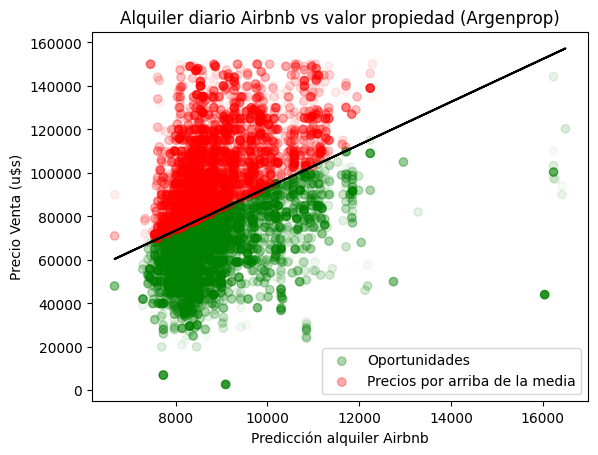

In [167]:
# plt.scatter(props2['precio_airbnb'], props2['Precio_vf'])

# Ajustar una línea de regresión
x = props2['precio_airbnb']
y = props2['Precio_vf']
coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef)
plt.plot(x, poly1d_fn(x), color='black')  # Línea de tendencia

# Colorear puntos por encima y por debajo de la línea de tendencia
mask_below = y < poly1d_fn(x)
mask_above = y >= poly1d_fn(x)
plt.scatter(x[mask_below], y[mask_below], color='green', label='Oportunidades',alpha=props2.dist_norms)
plt.scatter(x[mask_above], y[mask_above], color='red', label='Precios por arriba de la media',alpha=props2.dist_norms)

# Añadir título y etiquetas de los ejes
plt.title('Alquiler diario Airbnb vs valor propiedad (Argenprop)')
plt.xlabel('Predicción alquiler Airbnb')
plt.ylabel('Precio Venta (u$s)')
plt.legend()

# Mostrar el gráfico
plt.show()

In [168]:
#Calculo ratio de precio alquiler sobre valor propiedad
props2['airbnb_usd'] = props2['precio_airbnb'] / TDC_airbnb
props2['armortiza'] = props2['Precio_vf'] / (props2['precio_airbnb'] / TDC_airbnb)
props2['armortiza']

0        5316.298675
1        7629.050416
2       11613.998022
3       10875.864673
4        5995.182504
            ...     
6664    11630.500130
6665    12413.379282
6666     9463.630614
6667     9961.716436
6668    13257.437256
Name: armortiza, Length: 6669, dtype: float64

In [169]:
#Calculo el rendimiento anualizado
props2['ingreso_anualizado_usd'] = (props2['precio_airbnb'] / TDC_airbnb) * 365

props2['ROI'] = round((props2['ingreso_anualizado_usd'] / props2['Precio_vf']) * 100,2)
props2['ROI']

0       6.87
1       4.78
2       3.14
3       3.36
4       6.09
        ... 
6664    3.14
6665    2.94
6666    3.86
6667    3.66
6668    2.75
Name: ROI, Length: 6669, dtype: float64

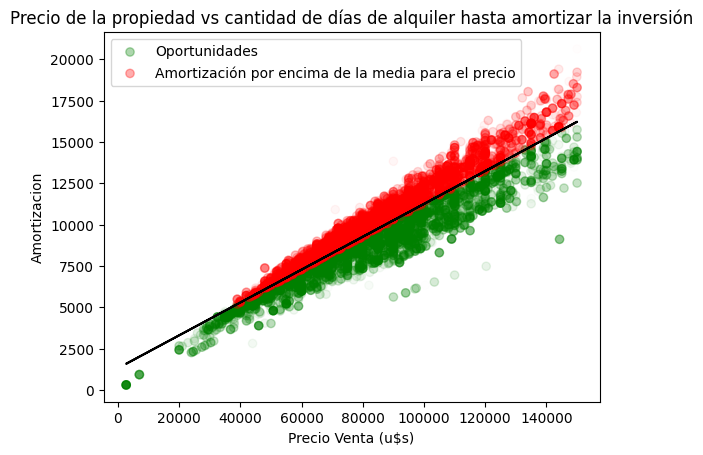

In [170]:
# plt.scatter(props2['precio_airbnb'], props2['Precio_vf'])

# Ajustar una línea de regresión
y = props2['armortiza']
x = props2['Precio_vf']
coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef)
plt.plot(x, poly1d_fn(x), color='black')  # Línea de tendencia

# Colorear puntos por encima y por debajo de la línea de tendencia
mask_below = y < poly1d_fn(x)
mask_above = y >= poly1d_fn(x)
plt.scatter(x[mask_below], y[mask_below], color='green', label='Oportunidades',alpha=props2.dist_norms)
plt.scatter(x[mask_above], y[mask_above], color='red', label='Amortización por encima de la media para el precio',alpha=props2.dist_norms)

# Añadir título y etiquetas de los ejes
plt.title('Precio de la propiedad vs cantidad de días de alquiler hasta amortizar la inversión')
plt.ylabel('Amortizacion')
plt.xlabel('Precio Venta (u$s)')
plt.legend()

# Mostrar el gráfico
plt.show()

In [171]:
props2['ROI'].mean()

4.241908831908832

In [172]:
#Genero una tabla por barrios con los principales indicadores resumenes
resultados_barrios = props2.groupby('neighbourhood')[['Precio_vf','precio_airbnb','airbnb_usd','armortiza', 'ingreso_anualizado_usd','ROI']].median().sort_values(by='ROI', ascending=False)
# resultados_barrios.round(1).to_excel("resultados por barrio - Monoambientes.xlsx")
resultados_barrios

,Precio_vf,precio_airbnb,airbnb_usd,armortiza,ingreso_anualizado_usd,ROI
neighbourhood,,,,,,
Nueva Pompeya,35000.0,8207.705078,8.007517,4380.512842,2922.743652,8.330
Boca,58000.0,8827.149414,8.611853,5932.969802,3143.326172,6.150
Puerto Madero,65000.0,10297.874023,10.046706,5972.106560,3667.047852,6.110
Parque Patricios,57165.0,8238.107422,8.037178,7153.310577,2933.570068,5.100
Floresta,54500.0,7601.723145,7.416315,7225.183726,2706.955078,5.055
Villa Luro,57000.0,7894.142578,7.701602,7263.957187,2811.084961,5.025
San Nicolas,65000.0,8757.095703,8.543508,7390.095965,3118.380371,4.940
Barracas,73950.0,8999.220703,8.779728,7418.334221,3204.600586,4.920
Versalles,59900.0,8020.347656,7.824729,7616.876780,2856.026367,4.790


In [173]:
props2.shape

(6669, 47)

In [175]:
props2.shape

(6669, 47)

In [176]:
resultados_barrios.reset_index()

,neighbourhood,Precio_vf,precio_airbnb,airbnb_usd,armortiza,ingreso_anualizado_usd,ROI
0,Nueva Pompeya,35000.0,8207.705078,8.007517,4380.512842,2922.743652,8.330
1,Boca,58000.0,8827.149414,8.611853,5932.969802,3143.326172,6.150
2,Puerto Madero,65000.0,10297.874023,10.046706,5972.106560,3667.047852,6.110
3,Parque Patricios,57165.0,8238.107422,8.037178,7153.310577,2933.570068,5.100
4,Floresta,54500.0,7601.723145,7.416315,7225.183726,2706.955078,5.055
5,Villa Luro,57000.0,7894.142578,7.701602,7263.957187,2811.084961,5.025
6,San Nicolas,65000.0,8757.095703,8.543508,7390.095965,3118.380371,4.940
7,Barracas,73950.0,8999.220703,8.779728,7418.334221,3204.600586,4.920
8,Versalles,59900.0,8020.347656,7.824729,7616.876780,2856.026367,4.790
9,Balvanera,62000.0,8343.067383,8.139578,7663.109616,2970.945801,4.760


In [178]:
props3 = pd.DataFrame(props2.merge(resultados_barrios.reset_index(), how='left',left_on='neighbourhood',right_on='neighbourhood',suffixes=('','_barrio')))

props3['oportunidad'] = props3['ROI'] > props3['ROI_barrio']*1.1
props3['oportunidad2'] = props3['ROI'] > props3['ROI_barrio']*1.25
props3.head()

,Clase,Barrio,Ubicacion,Descripcion,Precio,Links,fecha_consulta,tipo_prop,operacion,Barrio_vf,...,ingreso_anualizado_usd,ROI,Precio_vf_barrio,precio_airbnb_barrio,airbnb_usd_barrio,armortiza_barrio,ingreso_anualizado_usd_barrio,ROI_barrio,oportunidad,oportunidad2
0,"Departamento en Venta en Caballito Norte, Caba...","Caballito Norte, Caballito",Beláustegui 1100,Monoambiente con Patio en Venta,USD 45.000+$10.000expensas,https://www.argenprop.com/departamento-en-vent...,2024_03_01,Departamento,Venta,Caballito Norte,...,3089.555420,6.87,82000.0,8597.474609,8.387780,9833.417791,3061.539795,3.710,True,True
1,"Departamento en Venta en Recoleta, Barrio Norte","Recoleta, Barrio Norte",Anchorena al 1800,Monoambiente en Venta en Recoleta,USD 72.000+$33.000expensas,https://www.argenprop.com/departamento-en-vent...,2024_03_01,Departamento,Venta,Recoleta,...,3444.727539,4.78,93150.0,9748.958008,9.511179,9562.997808,3471.580322,3.820,True,True
2,"Departamento en Venta en Almagro, Capital Federal","Almagro, Capital Federal",AVENIDA CORRIENTES 3800,Departamento Monoambiente en Venta en Almagro ...,USD 99.999,https://www.argenprop.com/departamento-en-vent...,2024_03_01,Departamento,Venta,Almagro,...,3142.727783,3.14,80000.0,8486.700195,8.279708,9721.391302,3022.093506,3.755,False,False
3,"Departamento en Venta en Recoleta, Barrio Norte","Recoleta, Barrio Norte",Paraguay al 2400,Departamento Monoambiente con Balcon a Estrena...,USD 95.000,https://www.argenprop.com/departamento-en-vent...,2024_03_01,Departamento,Venta,Recoleta,...,3188.252197,3.36,93150.0,9748.958008,9.511179,9562.997808,3471.580322,3.820,False,False
4,"Departamento en Venta en Almagro Sur, Almagro","Almagro Sur, Almagro",Boedo al 200,Monoambiente Gran Categoría C/ Excelentes Amen...,USD 48.400,https://www.argenprop.com/departamento-en-vent...,2024_03_01,Departamento,Venta,Almagro Sur,...,2946.699219,6.09,80000.0,8486.700195,8.279708,9721.391302,3022.093506,3.755,True,True


In [179]:
# props3.to_csv("Monoambients ARGENPROP con precios de AIRBNB.csv")

In [180]:
mapa_oportunidades = folium.Map(location=[-34.606, -58.431], zoom_start=13)

datos = props3.loc[(props3['oportunidad']) & (props3['dbscan'] > -1) & (props3['Precio_vf'] <= 60000)]

# Iterar sobre el DataFrame y agregar marcadores al mapa
for i, row in datos.iterrows():
    # Determinar el color del marcador según la variable 'oportunidad'
    color = 'green' if row['oportunidad'] else 'red'

    # Crear un marcador para cada propiedad
    folium.Marker(
        location=[row['latitud'], row['longitud']],
        popup=f"Precio: u$s{row['Precio_vf']}<br>Airbnb_usd: {round(row['airbnb_usd'],1)}<br>Descripcion: {row['Descripcion']}<br>ROI: {row['ROI']} vs ROI barrial {row['ROI_barrio']}<br>Publicacion: {row['Links']}",
        icon=folium.Icon(color=color)
    ).add_to(mapa_oportunidades)

# Mostrar el mapa
mapa_oportunidades.save('mapa_oportunidades.html')
mapa_oportunidades